# Imports

In [5]:
import cudf as pd
import cupy
import dask
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas
import random

from sklearn.metrics import root_mean_squared_error

from pyESN import ESN

os.environ["KERAS_BACKEND"] = "jax"
import tensorflow as tf

from cuml.svm import svr
from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_absolute_error
from keras import Sequential
from keras.src.layers import Input, LSTM, Dense, MaxPooling1D, Conv1D, Flatten
from pyswarms.single import GlobalBestPSO
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


def rrmse(actual, predicted) -> int:
    return root_mean_squared_error(actual, predicted) / np.mean(actual)


reset_seed()
dask.config.set(scheduler="threads", num_workers=30)



# Optimization Setup
## Genetic Algorithm

### CNN

In [2]:
class IndCNN:
    def __init__(self):
        self.fitness = None
        self.filters = 0
        self.kernel_size = 0
        self.pool = 0
        self.activation = None
        self.dense = 0
        self.epochs = 0

    def create_random(self):
        self.rand_filters()
        self.rand_kernel_size()
        self.rand_pool()
        self.rand_activation()
        self.rand_dense()
        return self

    def rand_filters(self):
        self.filters = random.randint(1, 500)

    def rand_kernel_size(self):
        self.kernel_size = random.randint(1, 50)

    def rand_pool(self):
        self.pool = random.randint(1, 50)

    def rand_activation(self):
        self.lstm_activation = random.choice(
            ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None])

    def rand_dense(self):
        self.dense = random.randint(1, 500)

    def rand_epochs(self):
        self.epochs = random.randint(10, 300)


class GACNN:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            self.create_ind(_)
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndCNN().create_random()
        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")
            loc_pop = self.population[:self.n_individuals - 1].copy()

            for j in range(int(self.n_individuals)):
                self.crossover(random.choice(loc_pop), random.choice(loc_pop))

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]

            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndCNN()
        ind.filters = random.choice([ind_a.filters, ind_b.filters])
        ind.kernel_size = random.choice([ind_a.kernel_size, ind_b.kernel_size])
        ind.pool = random.choice([ind_a.pool, ind_b.pool])
        ind.activation = random.choice([ind_a.activation, ind_b.activation])
        ind.dense = random.choice([ind_a.dense, ind_b.dense])
        ind.epochs = random.choice([ind_a.epochs, ind_b.epochs])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_filters(),
            ind.rand_kernel_size(),
            ind.rand_pool(),
            ind.rand_activation(),
            ind.rand_dense(),
            ind.rand_epochs()
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.filters == individual.filters and
                             ind.kernel_size == individual.kernel_size and
                             ind.pool == individual.pool and
                             ind.activation == individual.activation and
                             ind.dense == individual.dense and
                             ind.epochs == individual.epochs, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((x.shape[1], 1)),
                Conv1D(filters=64,
                       kernel_size=2,
                       activation=individual.activation),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(individual.dense, activation=individual.activation),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train, shuffle=False, verbose=False, epochs=individual.epochs)
                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Filters": ind.filters,
                "Kernel_Size": ind.kernel_size,
                "Pool": ind.pool,
                "Dense": ind.dense,
                "Epochs": ind.epochs,
                "Fitness": ind.fitness,
                "Activation": ind.activation,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-CNN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### ESN

In [3]:
class IndESN:
    def __init__(self):
        self.fitness = None
        self.n_reservoirs = 0
        self.sparsity = 0
        self.spectral_radius = 0
        self.noise = 0

    def create_random(self):
        self.rand_n_reservoirs()
        self.rand_sparsity()
        self.rand_spectral_radius()
        self.rand_noise()
        return self

    def rand_n_reservoirs(self):
        self.n_reservoirs = random.randint(2, 1000)

    def rand_sparsity(self):
        self.sparsity = random.uniform(0.1, 0.5)

    def rand_spectral_radius(self):
        self.spectral_radius = random.uniform(0.1, 1.9)

    def rand_noise(self):
        self.noise = random.uniform(0.0001, 0.8)


class GAESN:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = {}
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndESN().create_random()
        ind = self.get_fitness(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndESN()
        ind.fitness = random.choice([ind_a.fitness, ind_b.fitness])
        ind.n_reservoirs = random.choice([ind_a.n_reservoirs, ind_b.n_reservoirs])
        ind.sparsity = random.choice([ind_a.sparsity, ind_b.sparsity])
        ind.spectral_radius = random.choice([ind_a.spectral_radius, ind_b.spectral_radius])
        ind.noise = random.choice([ind_a.noise, ind_b.noise])
        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_n_reservoirs(),
            ind.rand_sparsity(),
            ind.rand_spectral_radius(),
            ind.rand_noise()
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.fitness == individual.fitness and
                             ind.n_reservoirs == individual.n_reservoirs and
                             ind.sparsity == individual.sparsity and
                             ind.spectral_radius == individual.spectral_radius and
                             ind.noise == individual.noise, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        model = ESN(n_inputs=x.shape[1],
                    n_outputs=1,
                    n_reservoir=individual.n_reservoirs,
                    sparsity=individual.sparsity,
                    spectral_radius=individual.spectral_radius,
                    noise=individual.noise,
                    random_state=SEED)
        cvs = []
        for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
            x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
            y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

            model.fit(x_train, y_train)

            cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))

            del x_train, x_test, y_train, y_test

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Reservoirs": ind.n_reservoirs,
                "Sparsity": ind.sparsity,
                "Spectral Radius": ind.spectral_radius,
                "Noise": ind.noise,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-ESN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### LSTM

In [4]:
class IndLSTM:
    def __init__(self):
        self.fitness = None
        self.lstm_units = 0
        self.epochs = 0
        self.batch_size = 0
        self.lstm_activation = None
        self.bias = None

    def create_random(self):
        self.rand_units()
        self.rand_epochs()
        self.rand_batch()
        self.rand_activation()
        self.rand_bias()
        return self

    def rand_units(self):
        self.lstm_units = random.randint(1, 300)

    def rand_epochs(self):
        self.epochs = random.randint(1, 100)

    def rand_batch(self):
        self.batch_size = random.randint(1, 300)

    def rand_activation(self):
        self.lstm_activation = random.choice(
            ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None])

    def rand_bias(self):
        self.bias = random.choice([False, True])


class GALSTM:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            self.create_ind(_)
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndLSTM().create_random()
        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")
            loc_pop = self.population[:self.n_individuals - 1].copy()

            for j in range(int(self.n_individuals)):
                self.crossover(random.choice(loc_pop), random.choice(loc_pop))

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]

            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndLSTM()
        ind.lstm_units = random.choice([ind_a.lstm_units, ind_b.lstm_units])
        ind.epochs = random.choice([ind_a.epochs, ind_b.epochs])
        ind.batch_size = random.choice([ind_a.batch_size, ind_b.batch_size])
        ind.lstm_activation = random.choice([ind_a.lstm_activation, ind_b.lstm_activation])
        ind.bias = random.choice([ind_a.bias, ind_b.bias])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_units(),
            ind.rand_epochs(),
            ind.rand_batch(),
            ind.rand_activation(),
            ind.rand_bias()
        ])
        return ind

    def get_fitness(self, individual):
        print(f"Units: {individual.lstm_units}" +
              f"Epochs: {individual.epochs}" +
              f"Batch Size: {individual.batch_size}" +
              f"Activation: {individual.lstm_activation}" +
              f"Bias: {individual.bias}")

        search = list(filter(lambda ind:
                             ind.lstm_units == individual.lstm_units and
                             ind.epochs == individual.epochs and
                             ind.batch_size == individual.batch_size and
                             ind.lstm_activation == individual.lstm_activation and
                             ind.bias == individual.bias, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((x.shape[1], 1)),
                LSTM(individual.lstm_units,
                     activation=individual.lstm_activation,
                     use_bias=individual.bias,
                     seed=SEED),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train, shuffle=False, verbose=False, epochs=individual.epochs,
                          batch_size=individual.batch_size)
                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Units": ind.lstm_units,
                "Epochs": ind.epochs,
                "Batch Size": ind.batch_size,
                "Activation": ind.lstm_activation,
                "Bias": ind.bias,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-LSTM ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### Random Forest


In [5]:
class IndRF:
    def __init__(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0

    def create_random(self):
        self.rand_estimators()
        self.rand_depth()
        self.rand_samples_split()
        self.rand_samples_leaf()
        return self

    def rand_estimators(self):
        self.estimators = random.randint(10, 300)

    def rand_depth(self):
        self.max_depth = random.randint(10, 300)

    def rand_samples_split(self):
        self.min_samples_split = random.randint(2, 50)

    def rand_samples_leaf(self):
        self.min_samples_leaf = random.randint(1, 50)


class GARF:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = {}
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndRF().create_random()
        ind = self.get_fitness(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndRF()
        ind.estimators = random.choice([ind_a.estimators, ind_b.estimators])
        ind.max_depth = random.choice([ind_a.max_depth, ind_b.max_depth])
        ind.min_samples_split = random.choice([ind_a.min_samples_split, ind_b.min_samples_split])
        ind.min_samples_leaf = random.choice([ind_a.min_samples_leaf, ind_b.min_samples_leaf])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_estimators(),
            ind.rand_depth(),
            ind.rand_samples_split(),
            ind.rand_samples_leaf(),
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.estimators == individual.estimators and
                             ind.max_depth == individual.max_depth and
                             ind.min_samples_split == individual.min_samples_split and
                             ind.min_samples_leaf == individual.min_samples_leaf, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        model = CudaRandomForest(random_state=SEED,
                                 n_estimators=individual.estimators,
                                 max_depth=individual.max_depth,
                                 min_samples_split=individual.min_samples_split,
                                 min_samples_leaf=individual.min_samples_leaf,
                                 n_streams=individual.estimators,
                                 n_bins=individual.min_samples_split)

        try:
            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": ind.estimators,
                "Max_depth": ind.max_depth,
                "Min_samples_split": ind.min_samples_split,
                "Min_samples_leaf": ind.min_samples_leaf,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-RF ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### SVR

In [6]:
class IndSVR:
    def __init__(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.kernel = None

    def create_random(self):
        self.rand_c()
        self.rand_epsilon()
        self.rand_kernel()
        return self

    def rand_c(self):
        self.c = random.uniform(0.00001, 20000)

    def rand_epsilon(self):
        self.epsilon = random.uniform(0.001, 1)

    def rand_kernel(self):
        self.kernel = random.choice(["poly", "rbf", "sigmoid"])


class GASVR:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        ind = IndSVR().create_random()
        ind = self.get_fitness(ind)
        self.population.append(ind)
        print(f'Ind:{i}')
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndSVR()
        ind.c = random.choice([ind_a.c, ind_b.c])
        ind.epsilon = random.choice([ind_a.epsilon, ind_b.epsilon])
        ind.kernel = random.choice([ind_a.kernel, ind_b.kernel])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_c(),
            ind.rand_epsilon(),
            ind.rand_kernel(),
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.c == individual.c and
                             ind.epsilon == individual.epsilon and
                             ind.kernel == individual.kernel, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            model = svr.SVR(C=individual.c,
                            epsilon=individual.epsilon,
                            kernel=individual.kernel)

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "C": ind.c,
                "Epsilon": ind.epsilon,
                "Kernel": ind.kernel,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-SVR ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### XGBoost

In [7]:
class IndXGB:
    def __init__(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.booster = None
        self.reg_lambda = 0
        self.reg_alpha = 0

    def create_random(self):
        self.rand_estimators()
        self.rand_depth()
        self.rand_booster()
        self.rand_lambda()
        self.rand_alpha()
        return self

    def rand_estimators(self):
        self.estimators = random.randint(1, 300)

    def rand_depth(self):
        self.max_depth = random.randint(1, 300)

    def rand_booster(self):
        self.booster = random.choice(["gbtree", "gblinear", "dart"])

    def rand_lambda(self):
        self.reg_lambda = random.uniform(0, 100)

    def rand_alpha(self):
        self.reg_alpha = random.uniform(0, 100)


class GAXGB:
    def __init__(self, dataset, n_individuals, n_generations, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = 0.5
        self.population = []
        self.iters = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        futures = [dask.delayed(self.create_ind)(_) for _ in range(self.n_individuals)]
        self.population = dask.compute(futures)[0]
        self.population = sorted(self.population, key=lambda a: a.fitness)
        best = self.population[0]
        self.iters.append(best)

    def create_ind(self, i):
        print(f'Ind:{i}')
        ind = IndXGB().create_random()
        ind = self.get_fitness(ind)
        return ind

    def init_gen(self):
        for i in range(self.n_generations):
            print(f"Iter: {i}")

            loc_pop = self.population[:self.n_individuals - 1].copy()

            dask.compute(
                [dask.delayed(self.crossover)(random.choice(loc_pop), random.choice(loc_pop)) for j in
                 range(int(self.n_individuals))])

            self.population = sorted(self.population, key=lambda a: a.fitness)
            best = self.population[0]
            self.iters.append(best)
            self.save_iters_csv()

            del loc_pop
            gc.collect()
            print(f"Best: {self.population[0].fitness}")

    def crossover(self, ind_a, ind_b):
        ind = IndXGB()
        ind.estimators = random.choice([ind_a.estimators, ind_b.estimators])
        ind.max_depth = random.choice([ind_a.max_depth, ind_b.max_depth])
        ind.booster = random.choice([ind_a.booster, ind_b.booster])
        ind.reg_lambda = random.choice([ind_a.reg_lambda, ind_b.reg_lambda])
        ind.reg_alpha = random.choice([ind_a.reg_alpha, ind_b.reg_alpha])

        if random.uniform(0, 1) < self.mutation_rate:
            ind = self.mutation(ind)

        ind = self.get_fitness(ind)
        self.population.append(ind)
        return ind

    def mutation(self, ind):
        random.choice([
            ind.rand_estimators(),
            ind.rand_depth(),
            ind.rand_booster(),
            ind.rand_lambda(),
            ind.rand_alpha()
        ])
        return ind

    def get_fitness(self, individual):
        search = list(filter(lambda ind:
                             ind.estimators == individual.estimators and
                             ind.max_depth == individual.max_depth and
                             ind.booster == individual.booster and
                             ind.reg_lambda == individual.reg_lambda and
                             ind.reg_alpha == individual.reg_alpha, self.population))

        if search:
            return search[0]

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        updater = "coord_descent" if individual.booster == "gblinear" else None

        try:
            model = XGBRegressor(device="cuda", random_state=SEED,
                                 n_estimators=individual.estimators,
                                 max_depth=individual.max_depth,
                                 booster=individual.booster,
                                 reg_lambda=individual.reg_lambda,
                                 reg_alpha=individual.reg_alpha,
                                 updater=updater)

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.get_fitness(individual)

        individual.fitness = int(np.array(cvs).mean())

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return individual

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            ind = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": ind.estimators,
                "Max_depth": ind.max_depth,
                "Booster": ind.booster,
                "Lambda": ind.reg_lambda,
                "Alpha": ind.reg_alpha,
                "Fitness": ind.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/GA-XGB ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



## Particle Swarm Optimization

### CNN

In [8]:
class PartCNN:
    def __init_(self):
        self.fitness = None
        self.filters = 0
        self.kernel_size = 0
        self.pool = 0
        self.activation = None
        self.dense = 0
        self.epochs = 0


class PSOCNN:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.ACTIVATIONS = ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None]
        self.run()

    def run(self):
        lower_bound = [1, 1, 1, 0, 1, 10]
        uppper_bound = [500, 50, 50, 7, 500, 300]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=6,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)

        fit_lst = []
        for j in range(self.n_particles):
            fit_lst.append(self.objective_function(parts[j]))

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr):
        particle = PartCNN()
        particle.filters = int(particle_arr[0])
        particle.kernel_size = int(particle_arr[1])
        particle.pool = int(particle_arr[2])
        particle.activation = self.ACTIVATIONS[int(particle_arr[3])]
        particle.dense = int(particle_arr[4])
        particle.epochs = int(particle_arr[5])

        search = list(filter(lambda par:
                             par.filters == particle.filters and
                             par.kernel_size == particle.kernel_size and
                             par.pool == particle.pool and
                             par.activation == particle.activation and
                             par.dense == particle.dense, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((x.shape[1], 1)),
                Conv1D(filters=64,
                       kernel_size=2,
                       activation=particle.activation),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(particle.dense, activation=particle.activation),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train, shuffle=False, verbose=False, epochs=particle.epochs)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))
                del x_train, x_test, y_train, y_test

        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr)

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Filters": part.filters,
                "Kernel_Size": part.kernel_size,
                "Pool": part.pool,
                "Dense": part.dense,
                "Epochs": part.epochs,
                "Fitness": part.fitness,
                "Activation": part.activation,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-CNN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### ESN

In [9]:
class PartESN:
    def __init_(self):
        self.fitness = None
        self.n_reservoirs = 0
        self.sparsity = 0
        self.spectral_radius = 0
        self.noise = 0


class PSOESN:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.run()

    def run(self):
        lower_bound = [2, 0.1, 0.1, 0.0001]
        uppper_bound = [1000, 0.5, 1.9, 0.8]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=4,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)

        fit_lst = []
        for j in range(self.n_particles):
            fit_lst.append(self.objective_function(parts[j]))

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr):
        particle = PartESN()
        particle.n_reservoirs = int(particle_arr[0])
        particle.sparsity = particle_arr[1]
        particle.spectral_radius = particle_arr[2]
        particle.noise = particle_arr[3]

        search = list(filter(lambda par:
                             par.n_reservoirs == particle.n_reservoirs and
                             par.sparsity == particle.sparsity and
                             par.spectral_radius == particle.spectral_radius and
                             par.noise == particle.noise, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        model = ESN(n_inputs=x.shape[1],
                    n_outputs=1,
                    n_reservoir=particle.n_reservoirs,
                    sparsity=particle.sparsity,
                    spectral_radius=particle.spectral_radius,
                    noise=particle.noise,
                    random_state=SEED)

        cvs = []
        for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
            x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
            y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

            model.fit(x_train, y_train)

            cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))
            del x_train, x_test, y_train, y_test

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Reservoirs": part.n_reservoirs,
                "Sparsity": part.sparsity,
                "Spectral Radius": part.spectral_radius,
                "Noise": part.noise,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-ESN ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df




### LSTM

In [10]:
class PartLSTM:
    def __init_(self):
        self.fitness = None
        self.lstm_units = 0
        self.epochs = 0
        self.batch_size = 0
        self.lstm_activation = None
        self.bias = None


class PSOLSTM:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.ACTIVATIONS = ["linear", "mish", "sigmoid", "softmax", "softplus", "softsign", "tanh", None]
        self.BIAS = [False, True]
        self.run()

    def run(self):
        lower_bound = [1, 1, 1, 0, 0]
        uppper_bound = [300, 100, 300, 7, 1]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=5,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)

        fit_lst = []
        for j in range(self.n_particles):
            fit_lst.append(self.objective_function(parts[j]))

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr):
        particle = PartLSTM()
        particle.lstm_units = int(particle_arr[0])
        particle.epochs = int(particle_arr[1])
        particle.batch_size = int(particle_arr[2])
        particle.lstm_activation = self.ACTIVATIONS[int(particle_arr[3])]
        particle.bias = self.BIAS[int(particle_arr[4])]

        search = list(filter(lambda par:
                             par.lstm_units == particle.lstm_units and
                             par.epochs == particle.epochs and
                             par.batch_size == particle.batch_size and
                             par.lstm_activation == particle.lstm_activation and
                             par.bias == particle.bias, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            tf.keras.backend.clear_session()
            model = Sequential([
                Input((x.shape[1], 1)),
                LSTM(particle.lstm_units,
                     activation=particle.lstm_activation,
                     use_bias=particle.bias,
                     seed=SEED),
                Dense(1),
            ])
            model.compile(loss='mse')

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train, shuffle=False, verbose=False, epochs=particle.epochs,
                          batch_size=particle.batch_size)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test)[0])))
                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr)

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "Units": part.lstm_units,
                "Epochs": part.epochs,
                "Batch Size": part.batch_size,
                "Activation": part.lstm_activation,
                "Bias": part.bias,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-LSTM ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### Random Forest


In [11]:
class PartRF:
    def __init_(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0


class PSORF:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.run()

    def run(self):
        lower_bound = [10, 10, 2, 1]
        uppper_bound = [300, 300, 50, 50]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=4,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)
        iter = int(len(self.particles) / self.n_particles)

        fit_lst = \
            dask.compute([dask.delayed(self.objective_function)(parts[j], iter) for j in range(self.n_particles)])[0]

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        return fit_lst

    def objective_function(self, particle_arr, i):
        particle = PartRF()
        particle.estimators = int(particle_arr[0])
        particle.max_depth = int(particle_arr[1])
        particle.min_samples_split = int(particle_arr[2])
        particle.min_samples_leaf = int(particle_arr[3])

        search = list(filter(lambda par:
                             par.estimators == particle.estimators and
                             par.max_depth == particle.max_depth and
                             par.min_samples_split == particle.min_samples_split and
                             par.min_samples_leaf == particle.min_samples_leaf, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            model = CudaRandomForest(random_state=SEED,
                                     n_estimators=particle.estimators,
                                     max_depth=particle.max_depth,
                                     min_samples_split=particle.min_samples_split,
                                     min_samples_leaf=particle.min_samples_leaf,
                                     n_streams=particle.estimators,
                                     n_bins=particle.min_samples_split)

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr, i)

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": part.estimators,
                "Max_depth": part.max_depth,
                "Min_samples_split": part.min_samples_split,
                "Min_samples_leaf": part.min_samples_leaf,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-RF ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### SVR

In [12]:
class PartSVR:
    def __init_(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.kernel = None


class PSOSVR:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.KERNELS = ["poly", "rbf", "sigmoid"]
        self.run()

    def run(self):
        lower_bound = [0.00001, 0.001, 0]
        uppper_bound = [20000, 1, 2]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=3,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)
        iter = int(len(self.particles) / self.n_particles)

        fit_lst = \
            dask.compute([dask.delayed(self.objective_function)(parts[j], iter) for j in range(self.n_particles)])[0]

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr, i):
        particle = PartSVR()
        particle.c = float(particle_arr[0])
        particle.epsilon = float(particle_arr[1])
        particle.kernel = self.KERNELS[int(particle_arr[2])]

        search = list(filter(lambda par:
                             par.c == particle.c and
                             par.epsilon == particle.epsilon and
                             par.kernel == particle.kernel, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            model = svr.SVR(C=particle.c,
                            epsilon=particle.epsilon,
                            kernel=particle.kernel)

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr, i)

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "C": part.c,
                "Epsilon": part.epsilon,
                "Kernel": part.kernel,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-SVR ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



### XGBoost

In [13]:
class PartXGB:
    def __init_(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.booster = None
        self.reg_lambda = 0
        self.reg_alpha = 0


class PSOXGB:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.iters = []
        self.BOOSTERS = ["gbtree", "gblinear", "dart"]
        self.run()

    def run(self):
        lower_bound = [1, 1, 0, 0, 0]
        uppper_bound = [300, 300, 2, 100, 100]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=5,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, parts):
        parts = np.round(parts)
        iter = int(len(self.particles) / self.n_particles)

        fit_lst = \
            dask.compute([dask.delayed(self.objective_function)(parts[j], iter) for j in range(self.n_particles)])[0]

        self.particles = sorted(self.particles, key=lambda a: a.fitness)
        best = self.particles[0]
        self.iters.append(best)
        self.save_iters_csv()

        gc.collect()
        return fit_lst

    def objective_function(self, particle_arr, i):
        particle = PartXGB()
        particle.estimators = int(particle_arr[0])
        particle.max_depth = int(particle_arr[1])
        particle.booster = self.BOOSTERS[int(particle_arr[2])]
        particle.reg_lambda = float(particle_arr[3])
        particle.reg_alpha = float(particle_arr[4])

        search = list(filter(lambda par:
                             par.estimators == particle.estimators and
                             par.max_depth == particle.max_depth and
                             par.booster == particle.booster and
                             par.reg_lambda == particle.reg_lambda and
                             par.reg_alpha == particle.reg_alpha, self.particles))

        if search:
            self.particles.append(search[0])
            return search[0].fitness

        x = self.dataset.drop("consumption", axis=1)
        y = self.dataset["consumption"]

        try:
            updater = "coord_descent" if particle.booster == "gblinear" else None
            model = XGBRegressor(device="cuda", random_state=SEED,
                                 n_estimators=particle.estimators,
                                 max_depth=particle.max_depth,
                                 booster=particle.booster,
                                 reg_lambda=particle.reg_lambda,
                                 reg_alpha=particle.reg_alpha,
                                 updater=updater)

            cvs = []
            for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
                x_train, x_test = x.iloc[i_train].to_cupy().get(), x.iloc[i_test].to_cupy().get()
                y_train, y_test = y.iloc[i_train].to_cupy().get(), y.iloc[i_test].to_cupy().get()

                model.fit(x_train, y_train)

                cvs.append(int(mean_absolute_error(y_test, model.predict(x_test))))

                del x_train, x_test, y_train, y_test


        except Exception as e:
            print(f"\n!!! Repeating objective function: {e}.")
            return self.objective_function(particle_arr, i)

        particle.fitness = int(np.array(cvs).mean())

        self.particles.append(particle)

        del x, y, cvs, i_train, i_test, model
        gc.collect()
        return particle.fitness

    def iters_dataframe(self):
        df = pd.DataFrame()
        for i in range(len(self.iters)):
            part = self.iters[i]
            df = pd.concat([df, pd.DataFrame({
                "#": i,
                "N_estimators": part.estimators,
                "Max_depth": part.max_depth,
                "Booster": part.booster,
                "Lambda": part.reg_lambda,
                "Alpha": part.reg_alpha,
                "Fitness": part.fitness,
                "Base Seed": self.seed,
            })])
        df = df.set_index("#")
        return df

    def save_iters_csv(self):
        pd_df = self.iters_dataframe().to_pandas()
        pd_df.to_csv(f"params/PSO-XGB ITERS SEED {self.seed}.csv", sep=";", decimal=",", index=True)
        del pd_df



# Optimization Run

In [ ]:
df = pd.read_csv('dataset - Palmas/elect_merged_selected.csv', sep=";", decimal=",", header=0).to_pandas()
df["date"] = pandas.to_datetime(df["date"], format="%Y-%m-%d")
df = df[df["date"] >= '2019-01-01']
df = df[df["date"] <= '2023-12-31']

df.set_index("date", inplace=True)

df = df.astype("float32")

df = pd.DataFrame(df)

x = df.drop("consumption", axis=1)
y = df["consumption"]

seeds = [1000, 2000, 3000]
for seed in seeds:
    GACNN(df, 30, 10, seed)
    GAESN(df, 30, 10, seed)
    PSOCNN(df, 30, 10, seed)
    PSOESN(df, 30, 10, seed)




# Optimization Results
## Fitness Evolution

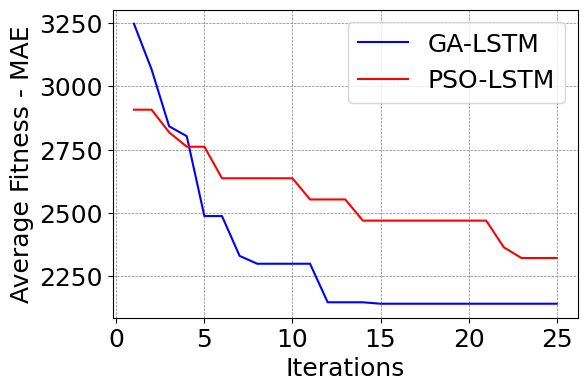

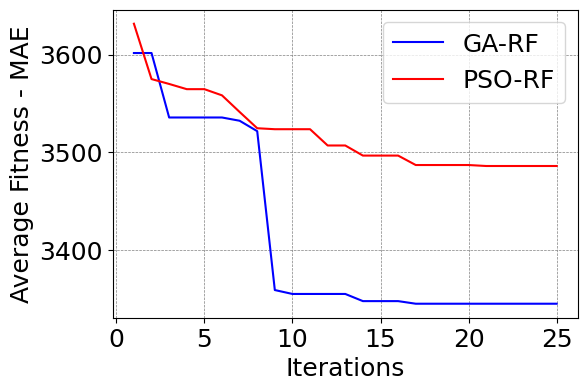

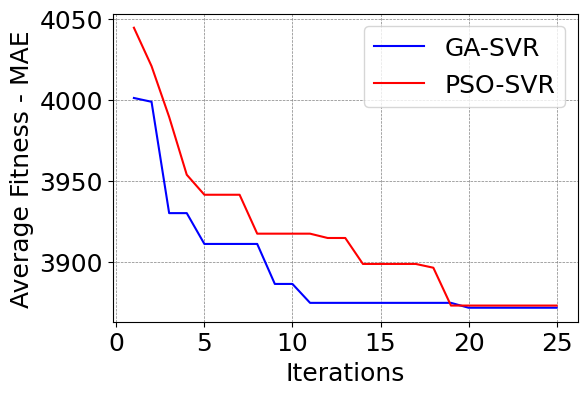

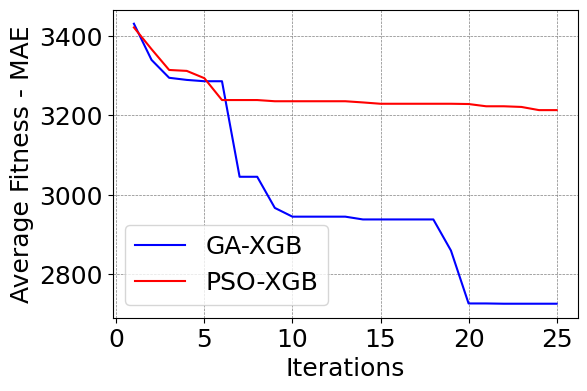

In [8]:

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.figure(figsize=(6, 4))
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=["blue", "red"])
    for optimizer in ["GA", "PSO"]:
        try:
            df = pandas.DataFrame()
            for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
                new_df = pandas.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";", decimal=",",
                                         header=0)
                df[seed] = new_df["Fitness"]
            plt.plot(range(1, len(df) + 1), [x for x in df.mean(axis=1)], label=f"{optimizer}-{model}")
        except Exception as e:
            continue

    plt.xlabel('Iterations')
    plt.ylabel('Average Fitness - MAE')

    ax = plt.gca()
    ax.set_facecolor('white')
    plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
    plt.legend(facecolor='white')
    plt.savefig(f"Optimization Results/{model}.png", bbox_inches='tight')
    plt.show()


## Best Params

In [9]:
best = {}
for model in ["CNN", "ESN", "LSTM", "RF", "SVR", "XGB"]:
    df = pandas.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed in ["1000", "2000", "3000"]:
            try:
                new_df = pandas.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";", decimal=",",
                                         header=0)
                df = pandas.concat([df, new_df], axis=0)
            except Exception as e:
                continue

    df = df.sort_values(by=["Fitness"])
    df[df.isnull()] = None
    best[f"{model}"] = df[:1]



### CNN

In [11]:
best["CNN"].transpose()

,24
#,24
Filters,58
Kernel_Size,33
Pool,42
Dense,442
Epochs,198
Fitness,1565
Activation,None
Base Seed,3000
Particle Time start,1725582180.373873


### ESN

In [12]:
best["ESN"].transpose()

,10
#,10.000000
Reservoirs,386.000000
Sparsity,0.392422
Spectral Radius,0.539990
Noise,0.059340
Fitness,1417.000000
Base Seed,1000.000000
Particle Time start,NaN
Particle Time end,NaN
Particle Time Elapsed,NaN


### LSTM

In [10]:
best["LSTM"].transpose()

,19
Unnamed: 0,19
#,19
Units,115
Epochs,98
Batch Size,117
Activation,None
Bias,True
Fitness,2068
Particle Time start,1721644645.994498
Particle Time end,1721644656.301186


### RF

In [ ]:
best["RF"].transpose()

### SVR

In [ ]:
best["SVR"].transpose()

### XGB

In [ ]:
best["XGB"].transpose()